In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as an
import scipy
from scipy.sparse import csr_matrix
import sklearn
import gget
import scanpy.external as sce

# local
import plotting as plt2
import utils as ut

sc.settings.verbosity = 3  

# Load iHSC data

In [2]:
fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/scanpy/analysis.anndata.h5ad"
adata = sc.read_h5ad(fpath)
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]
sc.logging.print_memory_usage()
adata

Memory usage: current 3.01 GB, difference +3.01 GB


AnnData object with n_obs × n_vars = 8563 × 15065
    obs: 'n_genes', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'EC_score', 'EB_score', 'FB_score', 'HSC_score', 'MK_score', 'new_cluster', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'Chromosome', 'Start', 'End', 'Strand', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'ensembl_id', 'tf', 'bj', 'hsc', 'EC', 'EB', 'FB', 'HSC', 'MK', 'cluster_genes'
    uns: 'HSC_vs_FB', 'HSC_vs_FB_pure', 'clusters', 'deg', 'fb_vs_hsc_up', 'go_annotations', 'hsc_v_fib_up', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'panglaodb', 'pca', 'scenic_transcription_factors', 'scrublet', 'tabula_sapiens_deg', 'umap', 'v5_tags'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'filtered_counts', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [3]:
# Filtering 
adata = adata[adata.obs['cluster_str'] != 'C6', :].copy()
adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C2', 'C5']), 'HSC-like', 'Fib-Like' )
adata.obs['group'].value_counts()

group
Fib-Like    6237
HSC-like    2199
Name: count, dtype: int64

# Load the marker lists

In [4]:
fpath = "../resources/Tabula_Sapiens.txt"
features = ut.load_pathway(fpath)  # Assuming 'ut.load_pathway' is a custom function to load the data

hsc_types = [x for x in features.columns if 'hemato' in x.lower()]

marker_dict = {}

all_hsc_genes = []

for col in hsc_types:
    type_name = f"{col.split("-")[0]}-HSC"
    gene_list = list(features[features[col]].index)
    gene_list = [x for x in gene_list if x in adata.var_names]
    all_hsc_genes += gene_list
    print(f"{type_name} with {len(gene_list)} genes...")
    marker_dict[type_name] = gene_list
    
    
all_hsc_genes = list(set(all_hsc_genes))
print(f"All HSC genes: {len(all_hsc_genes)}")

Blood-HSC with 69 genes...
Bone Marrow-HSC with 71 genes...
Lymph Node-HSC with 74 genes...
Spleen-HSC with 73 genes...
All HSC genes: 98


# DEG 

In [5]:
sc.tl.rank_genes_groups(
    adata, 
    groupby="group",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
    key_added='group_deg',
)

deg = sc.get.rank_genes_groups_df(
    adata, 
    group=None,
    key='group_deg',
)

deg.head()

ranking genes


... storing 'group' as categorical


    finished: added to `.uns['group_deg']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:11)


,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,Fib-Like,LILRA1,62.645008,2.736134,0.0,0.0,0.994549,0.941792
1,Fib-Like,TOMM70,61.193241,3.829926,0.0,0.0,0.983646,0.574352
2,Fib-Like,CEACAM3,60.680309,1.270079,0.0,0.0,1.000000,1.000000
3,Fib-Like,ZSWIM6,59.934292,3.513058,0.0,0.0,0.981401,0.634834
4,Fib-Like,AP5M1,56.491802,3.147447,0.0,0.0,0.957832,0.428377


    using 'X_pca' with n_pcs = 10
Storing dendrogram info using `.uns['dendrogram_cluster_str']`
categories: C1, C2, C3, etc.
var_group_labels: Fib-Like, HSC-like


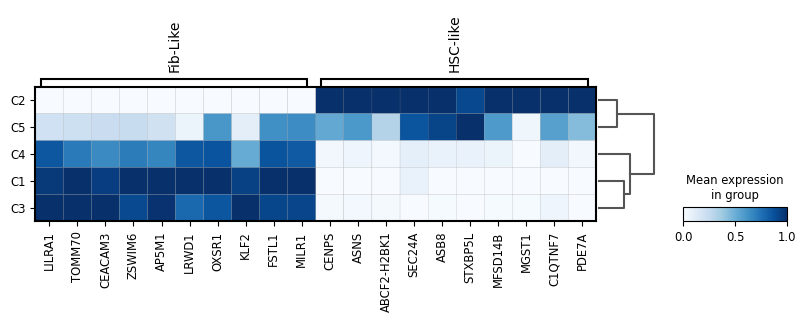

In [6]:
axs = sc.pl.rank_genes_groups_matrixplot(
    adata,
    n_genes=10,
    groupby='cluster_str',
    standard_scale='var', 
    cmap='Blues',
    key='group_deg',
)

categories: C1, C2, C3, etc.
var_group_labels: Fib-Like, HSC-like


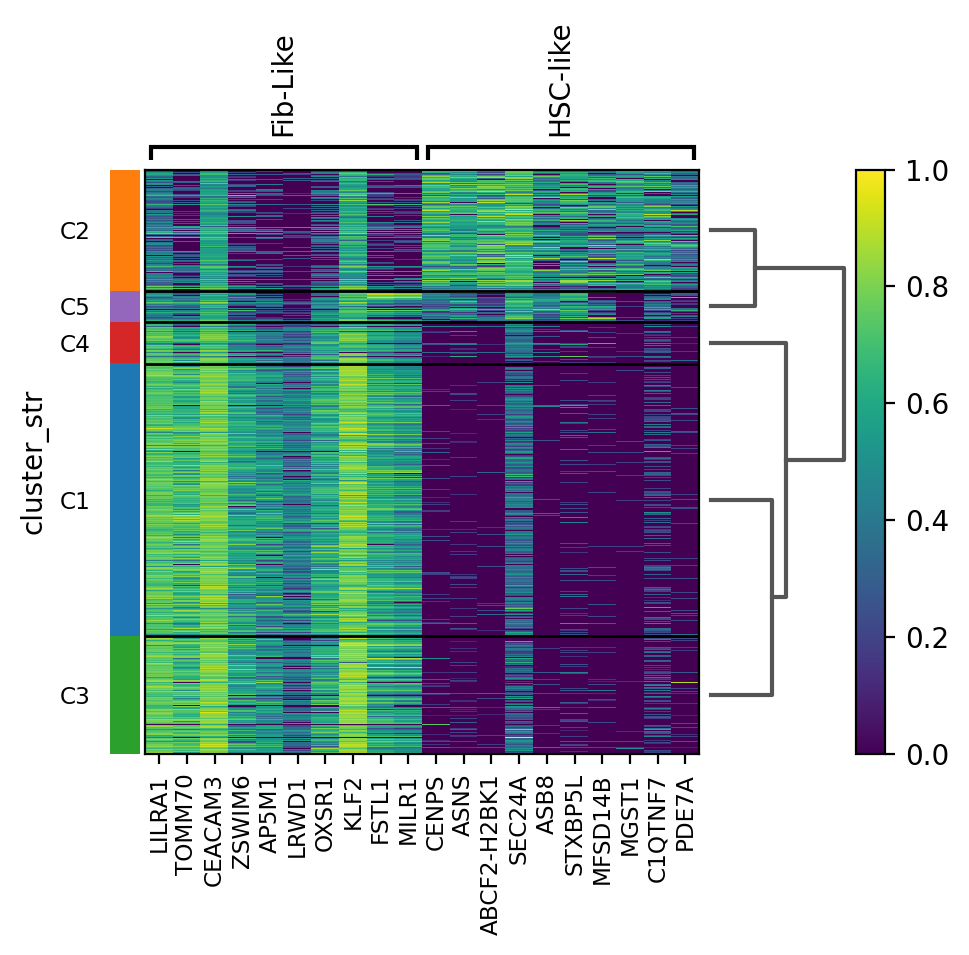

In [7]:
plt.rcParams['figure.dpi'] = 200

sc.pl.rank_genes_groups_heatmap(
    adata,
    n_genes=10,
    figsize=(5, 4),
    groupby='cluster_str',
    standard_scale='var', 
    key='group_deg',
    show_gene_labels=True,
    min_logfoldchange=1.0,
)

# Filtering

In [21]:
sig = deg.copy()
alpha = 0.05
sig = sig[sig['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > 1.0].reset_index(drop=True)
sig['diff'] = sig['pct_nz_group'] - sig['pct_nz_reference']
sig = sig.sort_values(by=['group', 'diff'], ascending=[False, False])
sig = sig[sig['names'].isin(all_hsc_genes)]

sig

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,diff
868,HSC-like,NFKBIA,10.620883,2.295335,2.382952e-26,4.116878e-25,0.208276,0.061889,0.146388
846,HSC-like,FAU,11.249861,1.224043,2.319578e-29,4.401064e-28,0.330605,0.187751,0.142854
1187,HSC-like,RPL7,3.743574,4.430145,1.814214e-04,9.366392e-04,0.057754,0.004329,0.053425
1203,HSC-like,RPS13,3.545678,2.884882,3.916042e-04,1.922920e-03,0.061846,0.011384,0.050463
1256,HSC-like,S100A8,3.124871,1.991751,1.778828e-03,7.716109e-03,0.063211,0.018759,0.044452
1249,HSC-like,RPS29,3.154974,1.016101,1.605126e-03,7.019221e-03,0.108686,0.065737,0.042949
1336,HSC-like,H3-3A,2.457788,2.398537,1.397959e-02,4.960022e-02,0.045930,0.010903,0.035027
34,Fib-Like,HMGB1,38.103474,2.628882,0.000000e+00,0.000000e+00,0.718454,0.228740,0.489714
145,Fib-Like,RPS24,15.293847,1.575474,8.403587e-53,2.626557e-51,0.362835,0.156435,0.206400
178,Fib-Like,RPL26,13.376385,1.048606,8.309163e-41,2.075913e-39,0.417669,0.228286,0.189383


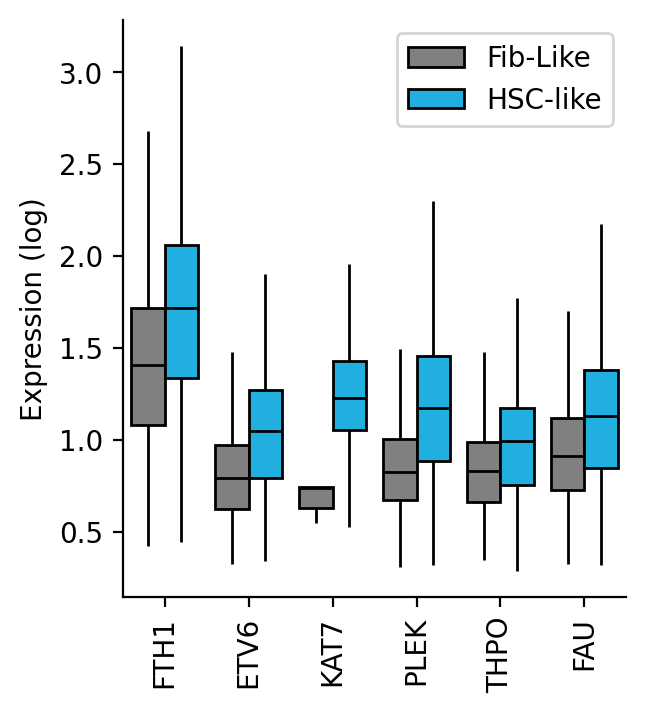

In [44]:
gene_list = [
    'FTH1',
    'FAU',
    # 'NFKBIA',
    # 'H3-3A',
    'PLEK',
    'ETV6',
    'KAT7',
    'THPO',
]

groupby = 'group'

pdf = adata[:, gene_list].to_df()
pdf = pdf.replace(0.0, pd.NA)
pdf['group'] = adata.obs[groupby].values

pdf = pd.melt(
    pdf,
    id_vars='group',
    value_vars=gene_list,
)

pdf = pdf.sort_values(by='group')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.25, 3.75

# Create boxplot without outliers and caps
sns.boxplot(
    data=pdf,
    x='variable',
    y='value',
    hue='group',
    showfliers=False,  # Remove outliers
    showcaps=False,    # Remove caps
    linecolor='k',
    palette=['grey', '#00BFFF']  # Set custom colors
)

plt.xlabel("")
plt.ylabel("Expression (log)")
plt.gca().tick_params(axis='x', rotation=90)

sns.move_legend(
    plt.gca(),
    title="",
    loc='best'
)

# Remove spines
sns.despine()

In [30]:
fpath = "../resources/GO_Biological_Process_2023.txt"
go = ut.load_pathway(fpath) 
print(f"{go.shape=}")

columns = [
    'Hematopoietic Progenitor Cell Differentiation (GO:0002244)',
    'Hematopoietic Stem Cell Differentiation (GO:0060218)',
    'Hematopoietic Stem Cell Proliferation (GO:0071425)',
    'Regulation Of Hematopoietic Progenitor Cell Differentiation (GO:1901532)',
    'Regulation Of Hematopoietic Stem Cell Differentiation (GO:1902036)',
    'Regulation Of Hematopoietic Stem Cell Proliferation (GO:1902033)',
]

go_hsc = list(go[go[columns].any(axis=1)].index)
go_hsc = [x for x in go_hsc if x in adata.var_names]
print(len(go_hsc))

go.shape=(14698, 5407)
46


In [31]:
sig = deg.copy()
alpha = 0.05
sig = sig[sig['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > 1.0].reset_index(drop=True)
sig['diff'] = sig['pct_nz_group'] - sig['pct_nz_reference']
sig = sig.sort_values(by=['group', 'diff'], ascending=[False, False])
sig = sig[sig['names'].isin(go_hsc)]

sig

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference,diff
626,HSC-like,PLEK,29.835363,4.189488,1.359351e-195,1.264113e-193,0.462938,0.046016,0.416922
750,HSC-like,ETV6,15.294097,2.394775,8.371447e-53,2.621951e-51,0.289677,0.080167,0.209510
800,HSC-like,TNFRSF13B,13.036226,5.410372,7.613324e-39,1.800545e-37,0.192815,0.006734,0.186081
729,HSC-like,PRRC2C,16.835896,1.153495,1.331587e-63,4.810638e-62,0.532060,0.370210,0.161850
1027,HSC-like,SETD1A,6.135474,1.763816,8.490567e-10,7.555251e-09,0.134152,0.047779,0.086373
1147,HSC-like,THPO,4.196901,1.113376,2.705917e-05,1.575141e-04,0.130059,0.072631,0.057428
1263,HSC-like,KAT7,3.078582,6.153645,2.079880e-03,8.924350e-03,0.045020,0.000962,0.044058
135,Fib-Like,KITLG,16.142502,2.205115,1.282350e-58,4.341260e-57,0.315857,0.095043,0.220814
171,Fib-Like,METTL3,13.713264,1.372519,8.456582e-43,2.192744e-41,0.348244,0.159163,0.189081


In [27]:
[x for x in go.columns if 'hemato' in x.lower()]

['Hematopoietic Progenitor Cell Differentiation (GO:0002244)',
 'Hematopoietic Stem Cell Differentiation (GO:0060218)',
 'Hematopoietic Stem Cell Proliferation (GO:0071425)',
 'Negative Regulation Of Hematopoietic Progenitor Cell Differentiation (GO:1901533)',
 'Regulation Of Hematopoietic Progenitor Cell Differentiation (GO:1901532)',
 'Regulation Of Hematopoietic Stem Cell Differentiation (GO:1902036)',
 'Regulation Of Hematopoietic Stem Cell Proliferation (GO:1902033)']

In [10]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
gene_list = [
    'FTH1',
    'FAU',
    'NFKBIA',
]


# sns.boxplot(
# )

In [ ]:
break

In [ ]:
sig = deg.copy()
n_genes = 5
alpha = 0.01
sig = sig[sig['pvals_adj'] <= alpha]
sig = sig[sig['logfoldchanges'] > 1.0].reset_index(drop=True)
# sig = sig[sig['names'].isin(hsc_genes)]

sig = sig.sort_values(by=['group', 'logfoldchanges'], ascending=[True, False])

print(f"{sig.shape=}")

sig.head(15)

In [ ]:
n_genes = 10
gene_list = list(sig['names'].head(n_genes).values)
database = 'ontology'

edf = gget.enrichr(gene_list, database=database)
edf
